# Applied Face Detection and Recognition

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE).

## Imports

In [87]:
import sys
import os
sys.path.append('lib/')
from esu_util import show_img, np_PIL, PIL_np
from PIL import Image
import face_recognition
from tqdm import tqdm_notebook
import numpy as np
from bs4 import BeautifulSoup
import requests
import json

Read image files in our dataset.

In [40]:
img_files = []
for root, dirs, files in os.walk('/home/fabian/datasets-live/moma/images'):
    for file in files:
        if file.endswith('.jpg'):
            img_files.append(f'{root}/{file}')
print(f'{len(img_files)} images found')
img_files = img_files[:100]

64780 images found


## Detect all faces and write to files

In [ ]:
savepoint = 0
border = 50 # Border around face in percent of face size
if not os.path.exists('faces_small'): os.makedirs('faces_small')

faces = 0
for n, path in enumerate(tqdm_notebook(img_files[savepoint:])):

    image = face_recognition.load_image_file(path)
    
    print(image.shape)
    
    face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=0, model="cnn")
    
    for face_nr, face_location in enumerate(face_locations):
        
        try:
                        
            top, right, bottom, left = face_location

            h = bottom-top
            w = right-left

            top -= int((h/100)*border)
            if top < 0: top = 0

            bottom += int((h/100)*border)
            if bottom > image.shape[0]: bottom = image.shape[0]

            left -= int((w/100)*border)
            if left < 0: left = 0

            right += int((w/100)*border)
            if right > image.shape[1]: bottom = image.shape[1]

            faces+=1
            file = path.split('/')[-1]
            face_file = f'faces_small/{file}_{face_nr+1}_{len(face_locations)}.jpg'
            pil_image = np_PIL(image[top:bottom, left:right])
            pil_image.save(face_file)
        
        except:
            continue
                
print(f'Found {faces} faces')

## Face Recognition

In [88]:
img_files = []
for root, dirs, files in os.walk('obama'):
    for file in files:
        if file.endswith('.jpg'):
            img_files.append(f'{root}/{file}')
print(f'{len(img_files)} images found')
print(img_files)

12 images found
['obama/obama_08.jpg', 'obama/trump.jpg', 'obama/obama_03.jpg', 'obama/obama_01.jpg', 'obama/biden.jpg', 'obama/obama_07.jpg', 'obama/obama_09.jpg', 'obama/obama_04.jpg', 'obama/obama_05.jpg', 'obama/obama_02.jpg', 'obama/obama_10.jpg', 'obama/obama_06.jpg']


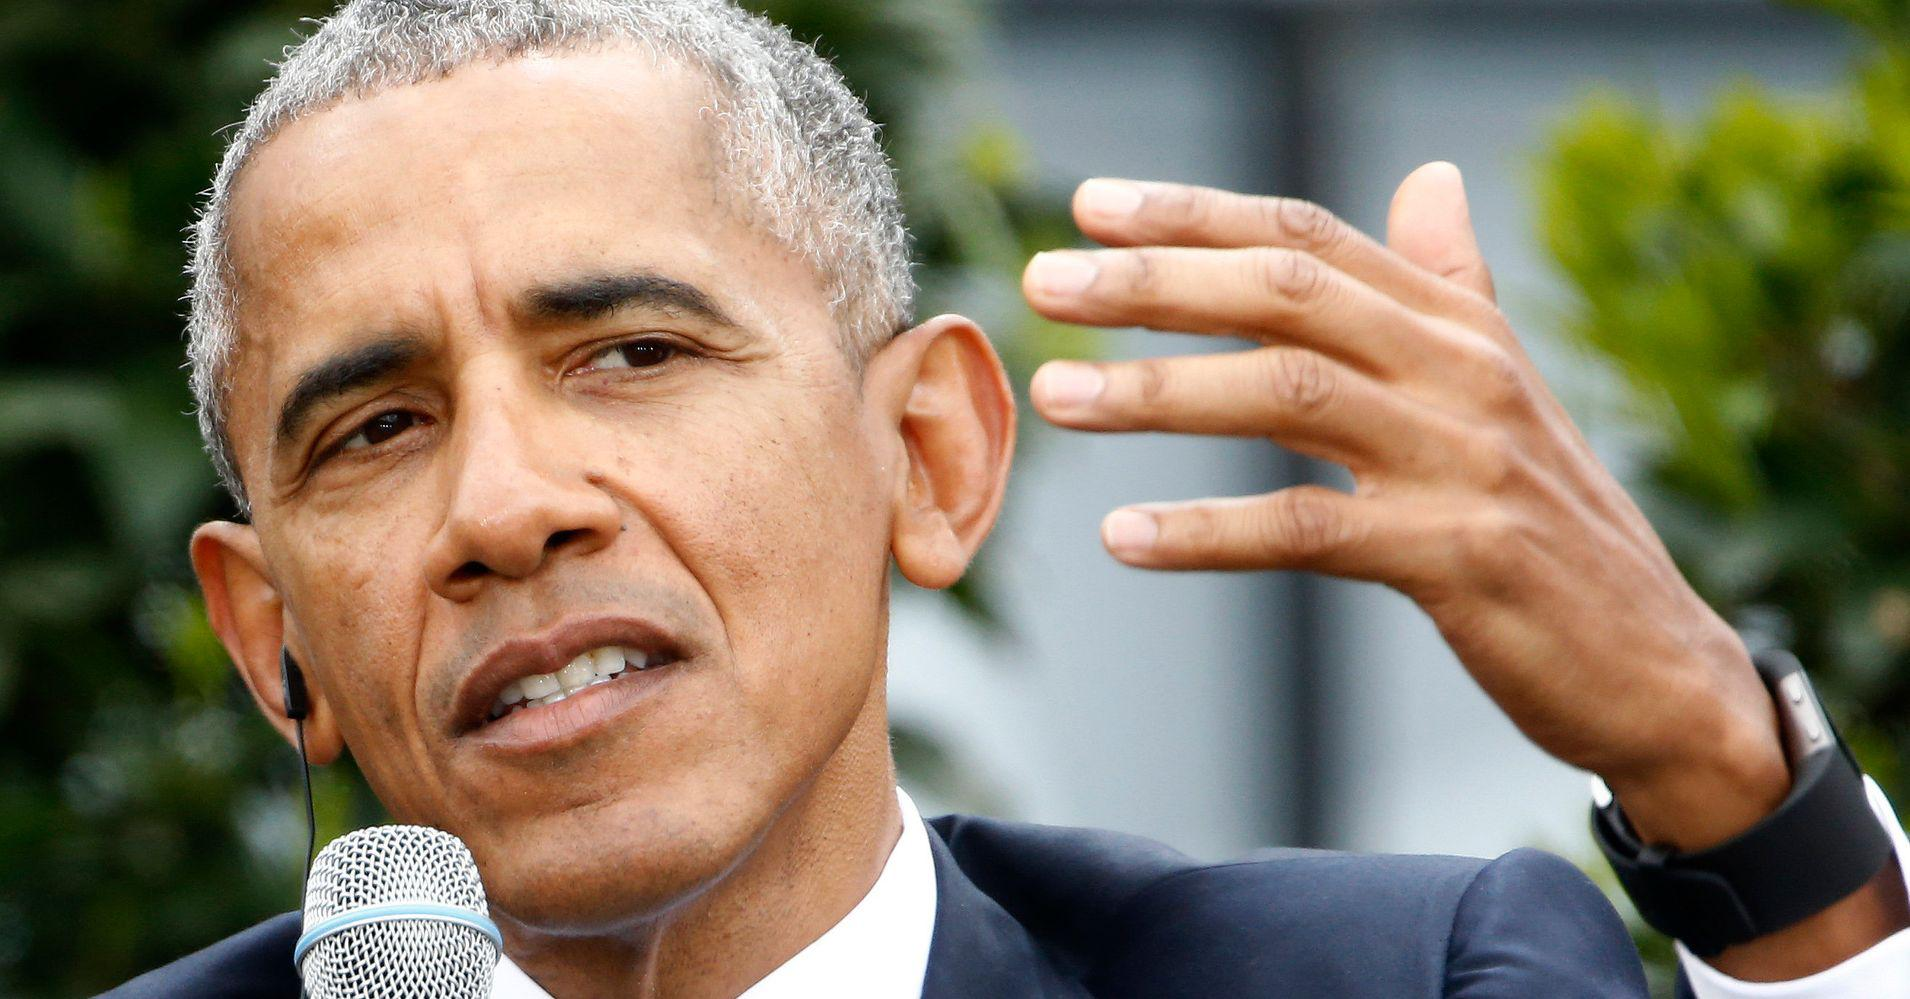

In [89]:
random_obama = np.random.choice(img_files)
show_img(Image.open(random_obama))

In [90]:
known_image = face_recognition.load_image_file(random_obama)
face_landmarks_list = face_recognition.face_landmarks(known_image)
print(face_landmarks_list)
obama_encoding = face_recognition.face_encodings(known_image)[0]

[{'chin': [(253, 508), (271, 579), (295, 651), (328, 720), (369, 783), (421, 839), (478, 886), (543, 914), (627, 905), (712, 874), (775, 821), (829, 755), (868, 684), (885, 600), (885, 519), (878, 437), (868, 353)], 'left_eyebrow': [(264, 447), (280, 393), (324, 355), (380, 336), (440, 334)], 'right_eyebrow': [(501, 312), (556, 283), (621, 270), (683, 280), (734, 312)], 'nose_bridge': [(480, 377), (484, 423), (488, 469), (494, 516)], 'nose_tip': [(462, 584), (493, 582), (527, 579), (563, 560), (596, 544)], 'left_eye': [(327, 457), (351, 430), (386, 415), (425, 421), (395, 439), (362, 452)], 'right_eye': [(585, 371), (612, 348), (648, 343), (686, 353), (655, 365), (620, 370)], 'top_lip': [(452, 735), (473, 679), (512, 643), (548, 641), (583, 621), (640, 625), (692, 657), (674, 658), (592, 653), (557, 668), (521, 676), (471, 724)], 'bottom_lip': [(692, 657), (662, 696), (619, 726), (581, 742), (543, 751), (497, 753), (452, 735), (471, 724), (531, 706), (568, 699), (604, 685), (674, 658)]

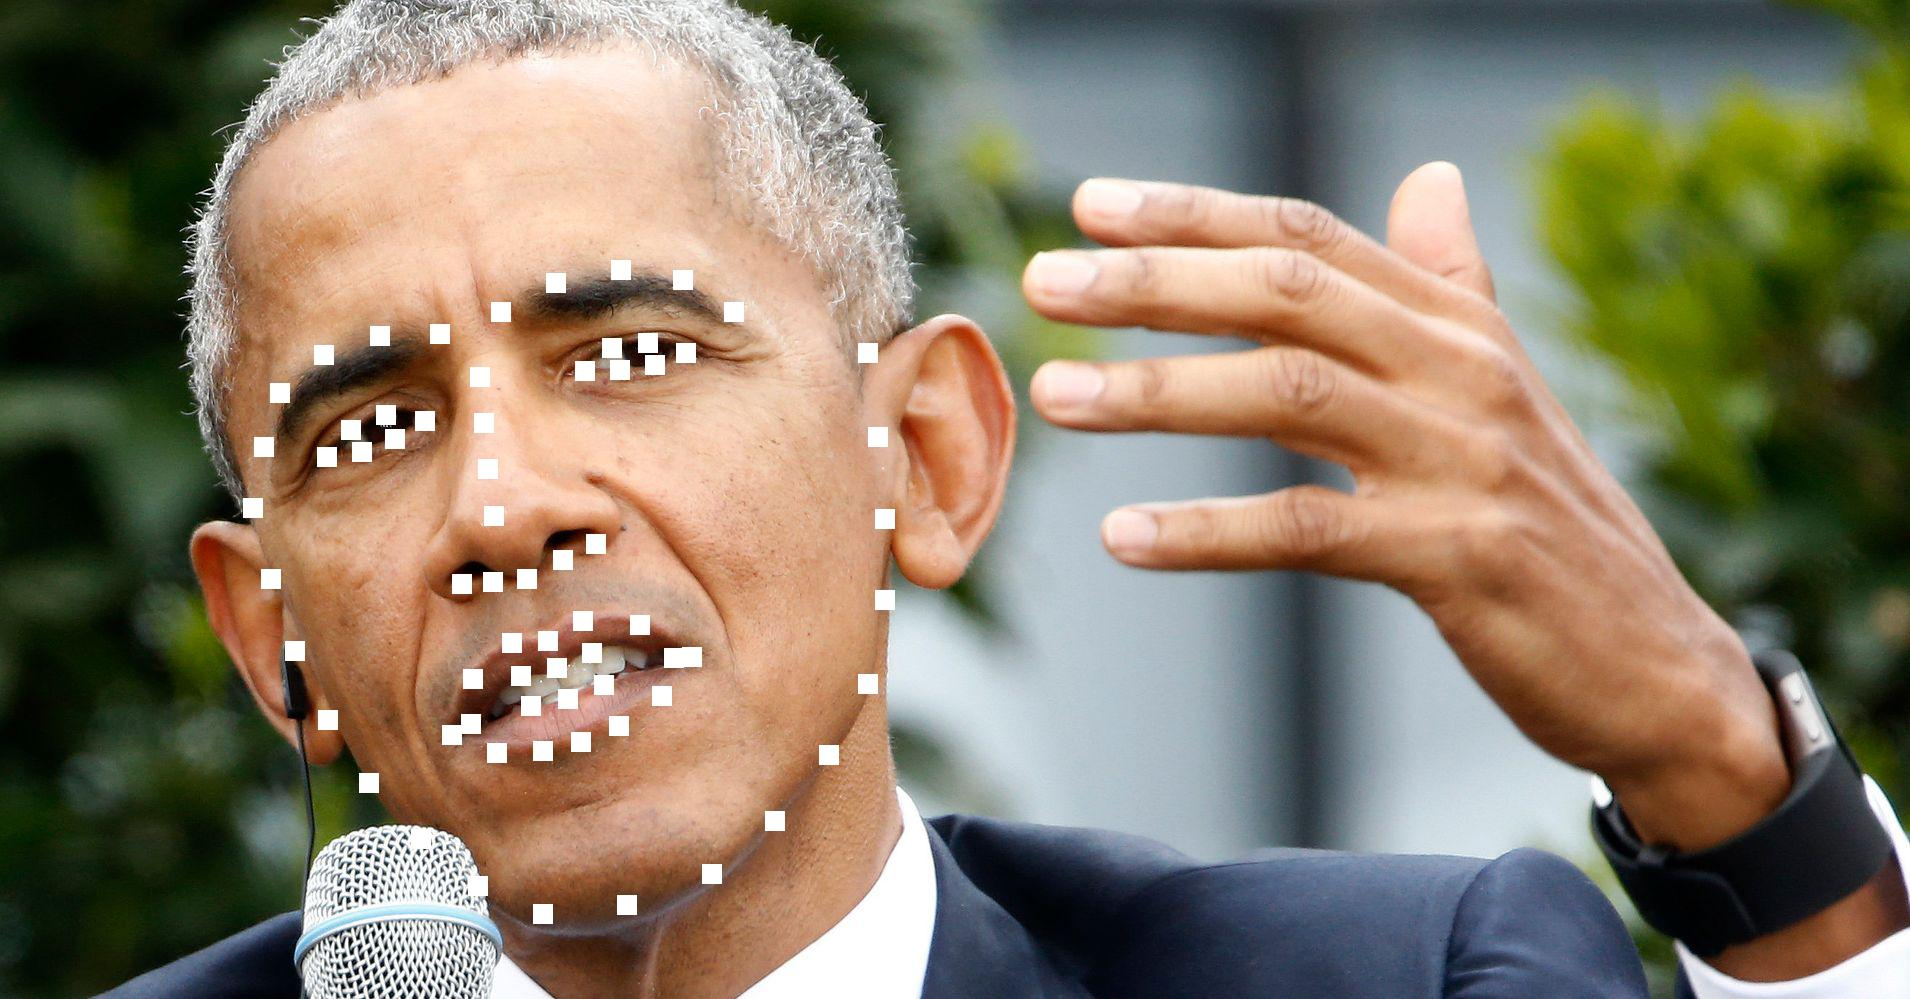

In [91]:
img = PIL_np(Image.open(random_obama))

for name, points in face_landmarks_list[0].items():
    for point in points:
        x = point[0]
        y = point[1]
        img[y-10:y+10,x-10:x+10,:] = 255

show_img(img)

In [40]:
for img_file in img_files:

    unknown_image = face_recognition.load_image_file(img_file)
    unknown_encoding = face_recognition.face_encodings(unknown_image)[0]
    results = face_recognition.compare_faces([obama_encoding], unknown_encoding)
    
    print(results, img_file)

[True] obama/obama_08.jpg
[False] obama/trump.jpg
[True] obama/obama_03.jpg
[True] obama/obama_01.jpg
[False] obama/biden.jpg
[True] obama/obama_07.jpg
[True] obama/obama_09.jpg
[True] obama/obama_04.jpg
[True] obama/obama_05.jpg
[True] obama/obama_02.jpg
[True] obama/obama_10.jpg
[True] obama/obama_06.jpg


## Am I in Google Images?

In [ ]:
query = 'Fabian Offert'
query='+'.join(query.split())
url = f'https://www.google.com/search?q={query}&source=lnms&tbm=isch'

header={'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:68.0) Gecko/20100101 Firefox/68.0'}

links = []
response = requests.get(url, headers=header)
if response.status_code == 200: # If we get a positive response from the server...
    soup = BeautifulSoup(response.content, 'html.parser') # Parse the page
    for div in soup.find_all("div",{"class":"rg_meta"}):
        link = json.loads(div.text)["ou"]
        links.append(link)
        
print(f'{len(links)} links found')
print(links)

In [50]:
if not os.path.exists('google'): os.makedirs('google')
known_image = face_recognition.load_image_file('fabian.jpg')
known_encoding = face_recognition.face_encodings(known_image)[0]

In [ ]:
files = []
for link in links[:10]:
    data = requests.get(link).content
    name = link.split('/')[-1]
    file = f'google/{name}'
    files.append(file)
    with open(file, 'wb') as f:
        f.write(data)

for file in files:
    unknown_image = face_recognition.load_image_file(file)
    unknown_encoding = face_recognition.face_encodings(unknown_image)[0]
    results = face_recognition.compare_faces([known_encoding], unknown_encoding)

    if results[0]:
        show_img(unknown_image)